In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime 
from sklearn.preprocessing import MinMaxScaler
import  tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense , LSTM , Input





In [12]:
now = datetime.now();
start= datetime(now.year-10, now.month , now.day)
end=now;
tricker='GOOG'
df=yf.download(tricker,start,end);

df= df[['Close']].copy() 
df.dropna(inplace=True)

[*********************100%***********************]  1 of 1 completed


In [13]:
# traning_data=df.Close[0:int(len(df)*0.7)]
# testing_data=df.Close[int(len(df)*0.7):]


In [14]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(df.values)


In [15]:
x_train = []
y_train = []

for i in range(100, len(scaled_data)):
    x_train.append(scaled_data[i-100:i])
    y_train.append(scaled_data[i, 0])

x_train = np.array(x_train)
y_train = np.array(y_train)

print(x_train.shape)  # (samples, 100, 1)
print(y_train.shape)

(2414, 100, 1)
(2414,)


In [16]:
model = Sequential()
model.add(Input(shape=(100,1)))
model.add(LSTM(128, activation='tanh', return_sequences=True))
model.add(LSTM(64))
model.add(Dense(25))
model.add(Dense(1))

In [17]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=50, batch_size=32)

model.summary()
model.save("stock_lstm_model_.keras")

Epoch 1/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 29s 281ms/step - loss: 0.0029
Epoch 2/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 22s 283ms/step - loss: 2.6290e-04
Epoch 3/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 22s 291ms/step - loss: 2.5613e-04
Epoch 4/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 22s 291ms/step - loss: 2.6488e-04
Epoch 5/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 22s 286ms/step - loss: 2.4260e-04
Epoch 6/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 22s 280ms/step - loss: 2.6271e-04
Epoch 7/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 22s 289ms/step - loss: 2.4842e-04
Epoch 8/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 23s 299ms/step - loss: 1.9075e-04
Epoch 9/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 24s 315ms/step - loss: 2.1286e-04
Epoch 10/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 23s 297ms/step - loss: 1.9435e-04
Epoch 11/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 24s 310ms/step - loss: 1.7926e-04
Epoch 12/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 23s 297ms/step - loss: 2.1028e-04
Epoch 13/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 24s 306ms/step - loss: 1.9874e-04
Epoch 14/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 22s 293ms/step - loss: 1.

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 128)       │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,625 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 352,859 (1.35 MB)

 Trainable params: 117,619 (459.45 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 235,240 (918.91 KB)

In [20]:
last_100_days = scaled_data[-100:]
current_input = last_100_days.reshape(1, 100, 1)

last_date = df.index[-1]
future_end = pd.Timestamp("2027-02-01")
future_days = (future_end - last_date).days



future_predictions = []
future_dates = []

current_date = last_date

for i in range(future_days):

    # predict next day
    next_price = model.predict(current_input, verbose=0)[0][0]

    # save
    future_predictions.append(next_price)

    # next date
    current_date += pd.Timedelta(days=1)
    future_dates.append(current_date)

    # slide window
    current_input = np.append(
        current_input[0, 1:, 0],
        next_price
    ).reshape(1, 100, 1)

future_predictions = np.array(future_predictions)

future_df = pd.DataFrame({
    "Date": future_dates,
    "Predicted_Close": future_predictions.flatten()
})

future_df.set_index("Date", inplace=True)

print(future_df.head())
print(future_df.tail())



            Predicted_Close
Date                       
2026-01-29         1.008719
2026-01-30         1.018588
2026-01-31         1.028678
2026-02-01         1.038634
2026-02-02         1.048391
            Predicted_Close
Date                       
2027-01-28         2.223235
2027-01-29         2.223239
2027-01-30         2.223243
2027-01-31         2.223247
2027-02-01         2.223251


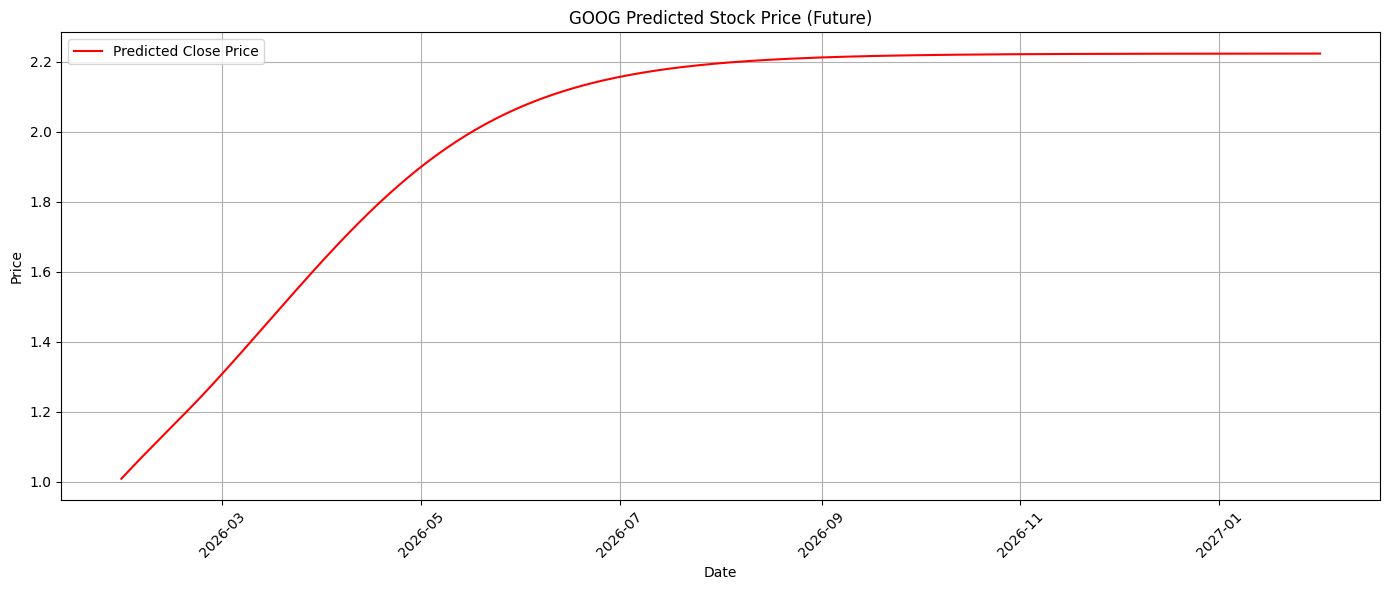

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

plt.plot(
    future_df.index,
    future_df["Predicted_Close"],
    label="Predicted Close Price",
    color="red"
)

plt.title("GOOG Predicted Stock Price (Future)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(16, 7))

plt.plot(
    future_df.index,
    future_df["Predicted_Close"],
    linewidth=2.5,
    linestyle='-',
    marker='o',
    markersize=3,
    label="Predicted Close Price"
)

plt.title("GOOG Future Price Prediction (2026–2027)", fontsize=16, fontweight="bold")
plt.xlabel("Date", fontsize=12)
plt.ylabel("Price (USD)", fontsize=12)

# Improve date formatting
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))   # every 2 months
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)

plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.tight_layout()

plt.show()

NameError: name 'future_df' is not defined

<Figure size 1600x700 with 0 Axes>